In [18]:
!pip install -qU torchinfo datasets

# DistilBert fine-tuning

- 1. Task: DistilBert를 통한 감정 분류입니다.

        1) 상세 설명: 뉴스 기사를 불러와 다중 분류를 진행합니다.

        2) 2주차 과제와 동일한 구조의 데이터셋을 사용하고 있기 때문에 데이터셋을 로드하는 과정에서는 2주차와 유사한 코드를 복사하여 사용하겠습니다. 단, 2주차에서 진행하지 않았던 텍스트 길이에 대한 EDA를 진행하겠습니다.

- 2. 더 해볼 과제:

        1) max_len에 대한 비교

        2) freeze와 full에 대한 비교

- 3. 특이 사항:

        1) parameter 수와 훈련 시간을 비교해보아야 합니다. 왜냐하면 freeze와 full 방식은 훈련 가능한 파라미터 수 차이가 굉장히 크기 때문입니다.

    

## 1. [My Code] Data Load

- 데이터셋을 불러옵니다.

- train, val, test로 분류합니다

    1) train : 120000 개

    2) val: 3800개

    3) test: 3800개

- 텍스트의 길이 분포도를 계산하여, max_len의 평균과 표준편차, 중앙값등을 계산해보겠습니다.

### 1.1 [My Code] Model Config

In [19]:
import torch
# 모델 config입니다.
model_name = "distilbert-base-uncased"
ds_name = "fancyzhx/ag_news"

test_size = 0.5
random_state = 42
batch_size = 64
max_len_dict = {'max_len_1' : 400, 'max_len_2': 230}

results_dir = './results/week3_basic'
lr = 0.001
n_epochs = 10

### 1.2 [My Code] Load Data and split it into Train, Val, Test

In [20]:
from transformers import DistilBertTokenizer
from datasets import load_dataset

# distilbert tokenizer를 사용합니다.
# 데이터셋은 뉴스 기사 데이터셋입니다.
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
ds = load_dataset(ds_name)

In [21]:
# train, val, test로 데이터 나누기
from sklearn.model_selection import train_test_split

print(ds, end='\n\n')

x_train = ds['train']['text']
y_train = ds['train']['label']

x_test = ds['test']['text']
y_test = ds['test']['label']

x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=test_size,
    random_state=random_state
)

num = 0

print(f"x_train len: {len(x_train)}")
print(f"y_train len: {len(y_train)}")
print(f"sample train test = label : {y_train[num]}\n text:{x_train[num]}\n")

print(f"x_val len: {len(x_val)}")
print(f"y_val len: {len(y_val)}")
print(f"sample train test = label : {y_val[num]}\n text:{x_val[num]}\n")

print(f"x_test shape: {len(x_test)}")
print(f"y_test len: {len(y_test)}\n")
print(f"sample test test = label : {y_test[num]}\n text:{x_test[num]}\n")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

x_train len: 120000
y_train len: 120000
sample train test = label : 2
 text:Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

x_val len: 3800
y_val len: 3800
sample train test = label : 1
 text:Kidd #39;s lack of playing time hurting Nets Having Jason Kidd available for roughly 20 minutes a night is costing the New Jersey Nets. The New York Knicks took advantage of Kidd #39;s rationed minutes to get back in the game early and then capitalized on 

x_test shape: 3800
y_test len: 3800

sample test test = label : 1
 text:Fan v Fan: Manchester City-Tottenham Hotspur This weekend Manchester City entertain Spurs, and with last seasons seven-goal FA Cup epic between the two teams still fresh in the memory, 

### 1.3 [My Code] 텍스트 길이 분포 계산

- 통계량

    1) 평균: 대체로 230

    2) 표준편차: 대체로 64

    3) 왜도
    : 대체로 2 정도 나오는 것을 알 수 있습니다. 왜도가 0일 때 정규분포를 그리게 되며 양수일 때 right-skewed, 음수일 때 left-skewed 데이터를 형성합니다. 즉 해당 length 분포는 전체적으로 오른쪽으로 치우쳐있으며 극단적으로 긴 데이터가 존재한다는 것을 알 수 있습니다.

    4) 첨도:
    : 대체로 10 정도 나오는 것을 알 수 있습니다. scipy.kurtois로 구한 초과첨도는 0을 기준으로 양수면 정규분포에 비해 봉우리가 훨씬 뾰족하고 음수면 봉우리가 완만합니다. 해당 데이터는 굉장히 봉우리가 뾰족하게 형성되어 있음을 알 수 있습니다. 이는 평균을 기준으로 데이터가 멀리 분포해 있음을 알려줍니다.

- max_len에 따른 metric 변화를 비교해보기 위하여 max_len이 400일 때와 230일 때 2개로 데이터셋을 각각 build해보겠습니다.

    1) max_len_2가 230인 것은 평균 혹은 중앙값이 230정도 형성되기 때문입니다. 따라서, 전체 텍스트의 절반은 전혀 안잘리고, 텍스트를 모두 사용하게 됩니다.

    2) max_len_1이 400인 것은 다음처럼 해석할 수 있습니다. 평균이 230에 표준편차가 60정도 나오기 때문에 2.5 표준편차 정도를 더하게 됩니다. 평균으로부터 2.5 표준편차만큼 큰 값까지는 정규분포를 가정할 때 전체 데이터의 99%를 포용하게 됩니다. 따라서 전체 데이터를 거의 다 쓴다고 말할 수 있습니다.

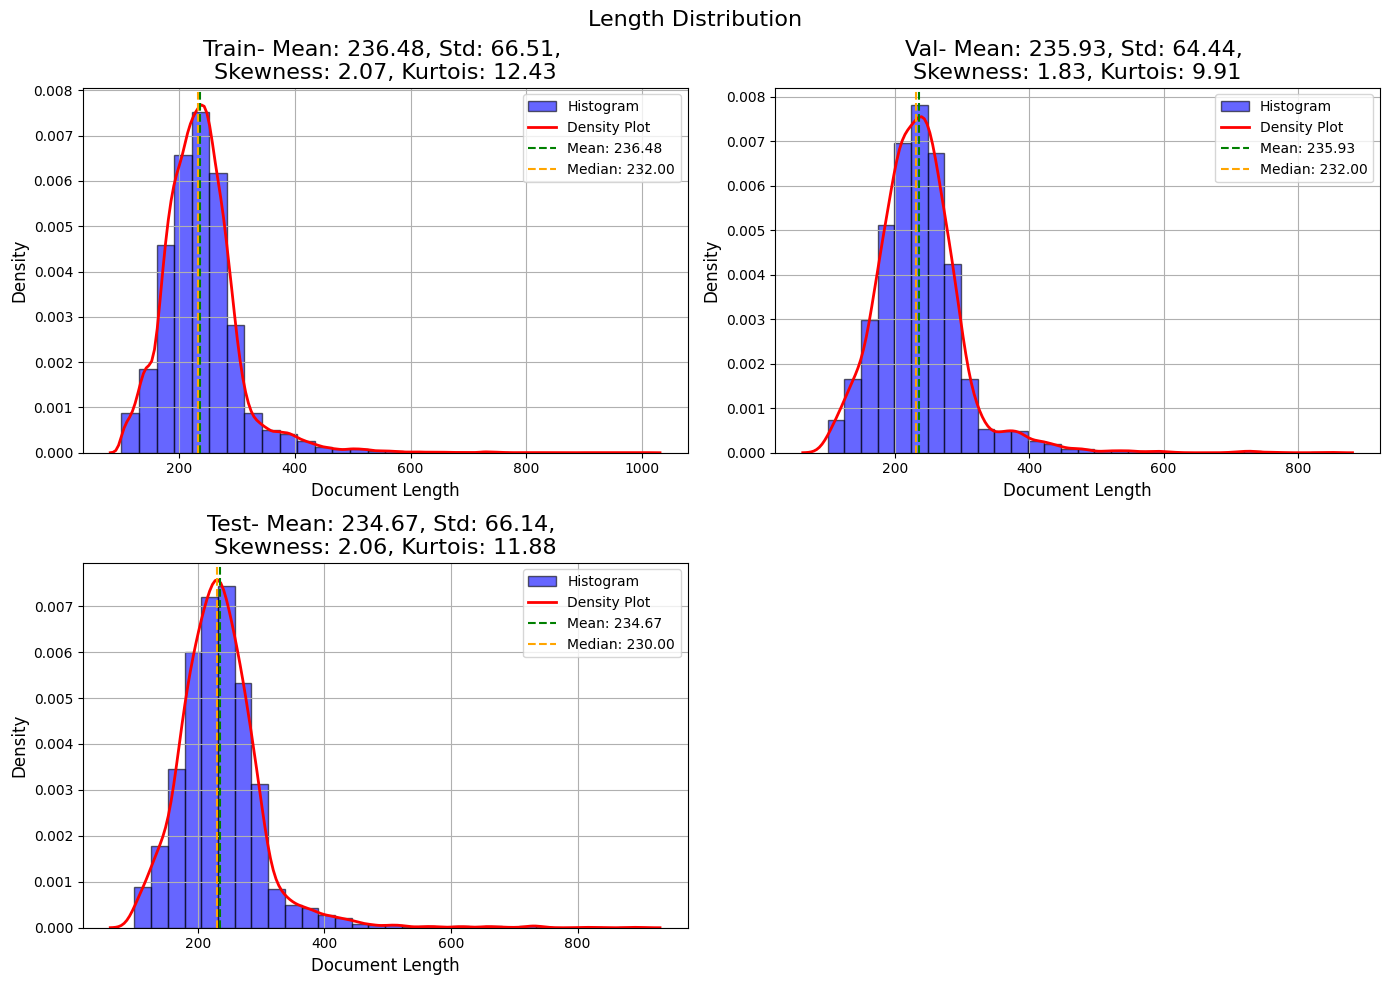

In [22]:
# 평균, 표준편차, 왜도, 첨도 계산
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis

def length_plot(data, name):
    plt.hist(data, bins=30, alpha=0.6, label=f'Histogram', color='blue', edgecolor='black', density=True)
    sns.kdeplot(data, label=f'Density Plot', color='red', linewidth=2)

    mean_value = np.mean(data)
    mean_value = np.mean(data)
    std_dev = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    median_value = np.median(data)

    plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    plt.title(f'{name}- Mean: {mean_value:.2f}, Std: {std_dev:.2f}, \nSkewness: {skewness:.2f}, Kurtois: {kurt:.2f}', fontsize=16)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)


plt.figure(figsize=(14,10))

for i, (data_lst, name) in enumerate(zip([x_train, x_val, x_test],['Train', 'Val', 'Test'])):
    plt.subplot(2,2,i+1)
    length_plot([len(data)for data in data_lst], name)

plt.suptitle("Length Distribution", fontsize=16)
plt.tight_layout()
plt.show()


### 1.4 [My Code] Label Distribution

- label : World (0), Sports (1), Business (2), Sci/Tech (3).

- 라벨이 고르게 분포되어 있음을 알 수 있습니다.

In [23]:
# text: a string feature.
import pandas as pd
import numpy as np
from IPython.display import display

df = pd.DataFrame(
    [
        pd.Series(y_train).value_counts(normalize=True).sort_index(),
        pd.Series(y_val).value_counts(normalize=True).sort_index(),
        pd.Series(y_test).value_counts(normalize=True).sort_index(),
    ],
    index = ['train','val','test'],
)

display(df)

,0,1,2,3
train,0.250000,0.250000,0.250000,0.250000
val,0.251316,0.246842,0.260789,0.241053
test,0.248684,0.253158,0.239211,0.258947


### 1.5 [My Code] 데이터셋 build

- max_len_1 : 400

- max_len_2 : 960

- max_len의 값에 따라서 데이터셋을 2개로 build 합니다.

In [ ]:
# 허깅페이스 데이터셋 형태로 바꾸기
# max_len_1과 max_len_2로 전처리를 진행한 데이터셋 2개를 각각 build합니다.
from datasets import Dataset, DatasetDict
def tokenize(batch, max_len):

  return tokenizer(
    batch["text"],
    padding="max_length",
    max_length = max_len,
    truncation=True,
    return_tensors = 'pt')


train_data = {
    'text': x_train,
    "label": y_train,
}

val_data = {
    'text': x_val,
    "label": y_val,
}

test_data = {
    'text': x_test,
    "label": y_test,
}

train_dataset = Dataset.from_dict(train_data)
train_dataset_1 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
train_dataset_2 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)

val_dataset = Dataset.from_dict(val_data)
val_dataset_1 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
val_dataset_2 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)

test_dataset = Dataset.from_dict(test_data)
test_dataset_1 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
test_dataset_2 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)

dataset_dict_1 = DatasetDict(
    {
        "train": train_dataset_1,
        "val": val_dataset_1,
        "test": test_dataset_1
    }
)

dataset_dict_2 = DatasetDict(
    {
        "train": train_dataset_2,
        "val": val_dataset_2,
        "test": test_dataset_2
    }
)

dataset_dict = DatasetDict(
    {
        "max_len_1" : dataset_dict_1,
        "max_len_2" : dataset_dict_2,
    }
)

## 2.[My Code] Model Load

: 허깅페이스의 trainer로 구현을 하는 것이 이번 과제의 추가 목표입니다.

- 모델을 로드합니다. 이 때, num_labels=2로 하면 이진 분류기 classifer를 달아줍니다.

- metrics: accuracy와 f1 score

- optimizer: Adam

- batch_size = 64,

- lr = 1e-3

### 2.1 [My Code] Max len에 따른 모델

- 모델 2개를 dict에 묶고, key는 max_len_1, max_len_2로 지정합니다.

- 분류기 이전의 모든 파라미터를 동결시키는 것과 동결시키지 않는 것의 차이를 확인하기 위하여 max_len_1, max_len_2로 freeze하지 않은 모델 또한 선언합니다.

- 따라서, 총 4개의 모델(max_len_1_freeze, max_len_2_freeze, max_len_1_full, max_len_2_full)의 metrics을 비교해보려고 합니다.

In [25]:
from transformers import DistilBertForSequenceClassification
from torchinfo import summary
# 내부의 d_model이 768임을 알 수 있습니다.
# distill bert는 Next Sentence Prediction을 위한 임베딩을 하지 않고 있음을 알 수 있습니다.
# 라벨 4개 분류 문제이므로 num_labels를 4로 두었습니다.
def build_model(freeze=True):
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

    # freeze가 true이면 동결하고 아니면 하지 않습니다.
    if freeze:
        for param in model.distilbert.parameters():
            param.requires_grad = False
    return model

model_dict = {
    'max_len_1-freeze' : build_model(freeze=True),
    'max_len_2-freeze' : build_model(freeze=True),
    'max_len_1-full' : build_model(freeze=False),
    'max_len_2-full' : build_model(freeze=False),
}

# 모델 정보 출력
for max_len_type in model_dict.keys():
    print(f"Model Summary: {max_len_type}")
    print(summary(model_dict[max_len_type], input_size=(batch_size, max_len_dict[max_len_type.split('-')[0]]), dtypes=[torch.int64]))
    print("\n\n")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-strea

Model Summary: max_len_1-freeze
Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [64, 4]                   --
├─DistilBertModel: 1-1                                  [64, 400, 768]            --
│    └─Embeddings: 2-1                                  [64, 400, 768]            --
│    │    └─Embedding: 3-1                              [64, 400, 768]            (23,440,896)
│    │    └─Embedding: 3-2                              [1, 400, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [64, 400, 768]            (1,536)
│    │    └─Dropout: 3-4                                [64, 400, 768]            --
│    └─Transformer: 2-2                                 [64, 400, 768]            --
│    │    └─ModuleList: 3-5                             --                        (42,527,232)
├─Linear: 1-2                                           [64, 768]                

## 3.[My Code] Training

- huggingface trainer를 사용하여 훈련을 진행합니다.

- 확실히 naive torch 버전으로 모델을 훈련시키는 것보다 코드가 간편해지는 것을 확인할 수 있습니다.

In [26]:
from transformers import TrainingArguments, Trainer
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score
import os
os.environ["WANDB_DISABLED"] = "true"

# compute metrics은 반드시 아래와 같이 dict의 형태로 나와야 합니다.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
    output_dir=results_dir,
    num_train_epochs=n_epochs,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=results_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none"
)

In [27]:
def build_triner(max_len_type, training_args):
    trainer = Trainer(
        model=model_dict[max_len_type],
        args=training_args,
        train_dataset=dataset_dict[max_len_type.split('-')[0]]["train"],
        eval_dataset=dataset_dict[max_len_type.split('-')[0]]["val"],
        compute_metrics=compute_metrics,
        optimizers=(Adam(model_dict[max_len_type].parameters(), lr=lr), None)
    )

    return trainer

trainer_dict = {
    'max_len_1-freeze' : build_triner('max_len_1-freeze', training_args),
    'max_len_2-freeze' : build_triner('max_len_2-freeze', training_args),
    'max_len_1-full' : build_triner('max_len_1-full', training_args),
    'max_len_2-full' : build_triner('max_len_2-full', training_args),
}

In [28]:
trainer_dict['max_len_1-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.308200,0.284792,0.901316,0.901406
2,0.270200,0.267137,0.904737,0.904447
3,0.255900,0.266528,0.905789,0.905394
4,0.246100,0.258871,0.911842,0.911979
5,0.236500,0.254516,0.909474,0.909163
6,0.228300,0.247434,0.912632,0.912371
7,0.221100,0.244917,0.915526,0.915420
8,0.212900,0.237650,0.918684,0.918611
9,0.208300,0.236719,0.921579,0.921604
10,0.202800,0.234059,0.920526,0.920516


TrainOutput(global_step=18750, training_loss=0.23903559895833335, metrics={'train_runtime': 3475.3184, 'train_samples_per_second': 345.292, 'train_steps_per_second': 5.395, 'total_flos': 1.2419261568e+17, 'train_loss': 0.23903559895833335, 'epoch': 10.0})

In [29]:
trainer_dict['max_len_2-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.308000,0.283060,0.901316,0.901436
2,0.268900,0.275045,0.902368,0.901972
3,0.255800,0.268665,0.908947,0.908528
4,0.245600,0.260103,0.910526,0.910679
5,0.236000,0.256235,0.909211,0.908904
6,0.227700,0.243796,0.915000,0.914743
7,0.220600,0.244014,0.915789,0.915669
8,0.213900,0.238778,0.917105,0.917042
9,0.207400,0.237128,0.916842,0.916800
10,0.202700,0.234680,0.919737,0.919666


TrainOutput(global_step=18750, training_loss=0.23866710286458334, metrics={'train_runtime': 2015.2845, 'train_samples_per_second': 595.449, 'train_steps_per_second': 9.304, 'total_flos': 7.1410754016e+16, 'train_loss': 0.23866710286458334, 'epoch': 10.0})

In [30]:
trainer_dict['max_len_1-full'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.386000,1.386068,0.260789,0.107887
2,1.386500,1.386218,0.251316,0.100949
3,1.386400,1.386412,0.246842,0.097737
4,1.386300,1.386438,0.241053,0.093640
5,1.386300,1.386373,0.241053,0.093640
6,1.386300,1.386252,0.260789,0.107887
7,1.386300,1.386205,0.251316,0.100949
8,1.386300,1.386325,0.246842,0.097737
9,1.386300,1.386303,0.246842,0.097737
10,1.386300,1.386314,0.246842,0.097737


TrainOutput(global_step=18750, training_loss=1.38631734375, metrics={'train_runtime': 9082.5541, 'train_samples_per_second': 132.121, 'train_steps_per_second': 2.064, 'total_flos': 1.2419261568e+17, 'train_loss': 1.38631734375, 'epoch': 10.0})

In [31]:
trainer_dict['max_len_2-full'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.387800,1.386129,0.251316,0.100949
2,1.386700,1.386184,0.251316,0.100949
3,1.386400,1.386425,0.246842,0.097737
4,1.386300,1.386438,0.241053,0.093640
5,1.386500,1.386443,0.241053,0.093640
6,1.386800,1.386254,0.251316,0.100949
7,1.386300,1.386206,0.251316,0.100949
8,1.386300,1.386300,0.251316,0.100949
9,1.386300,1.386298,0.251316,0.100949
10,1.386300,1.386310,0.246842,0.097737


TrainOutput(global_step=18750, training_loss=1.3865757161458334, metrics={'train_runtime': 5153.2716, 'train_samples_per_second': 232.862, 'train_steps_per_second': 3.638, 'total_flos': 7.1410754016e+16, 'train_loss': 1.3865757161458334, 'epoch': 10.0})

## 4.[My Code] Metric Plotting

In [32]:
# 테스트 데이터셋에 대한 예측과 평가를 진행합니다.
def cal_metrics(max_len_type):
    test_results = trainer_dict[max_len_type].predict(test_dataset=dataset_dict[max_len_type.split('-')[0]]["test"])
    metrics = test_results.metrics
    print(f"Test {max_len_type} Metrics:", "\n", "loss: ", metrics['test_loss'], "accuracy: ", metrics['test_accuracy'], "f1:", metrics['test_f1'])
    return metrics

metrics_dict = {
    'max_len_1-freeze': cal_metrics('max_len_1-freeze'),
    'max_len_2-freeze': cal_metrics('max_len_2-freeze'),
    'max_len_1-full': cal_metrics('max_len_1-full'),
    'max_len_2-full': cal_metrics('max_len_2-full'),
    }

Test max_len_1-freeze Metrics: 
 loss:  0.2045827955007553 accuracy:  0.9268421052631579 f1: 0.9268458011174346


Test max_len_2-freeze Metrics: 
 loss:  0.2066037356853485 accuracy:  0.9305263157894736 f1: 0.9305050585708469


Test max_len_1-full Metrics: 
 loss:  1.3862773180007935 accuracy:  0.2531578947368421 f1: 0.10228387011207145


Test max_len_2-full Metrics: 
 loss:  1.3862793445587158 accuracy:  0.2531578947368421 f1: 0.10228387011207145


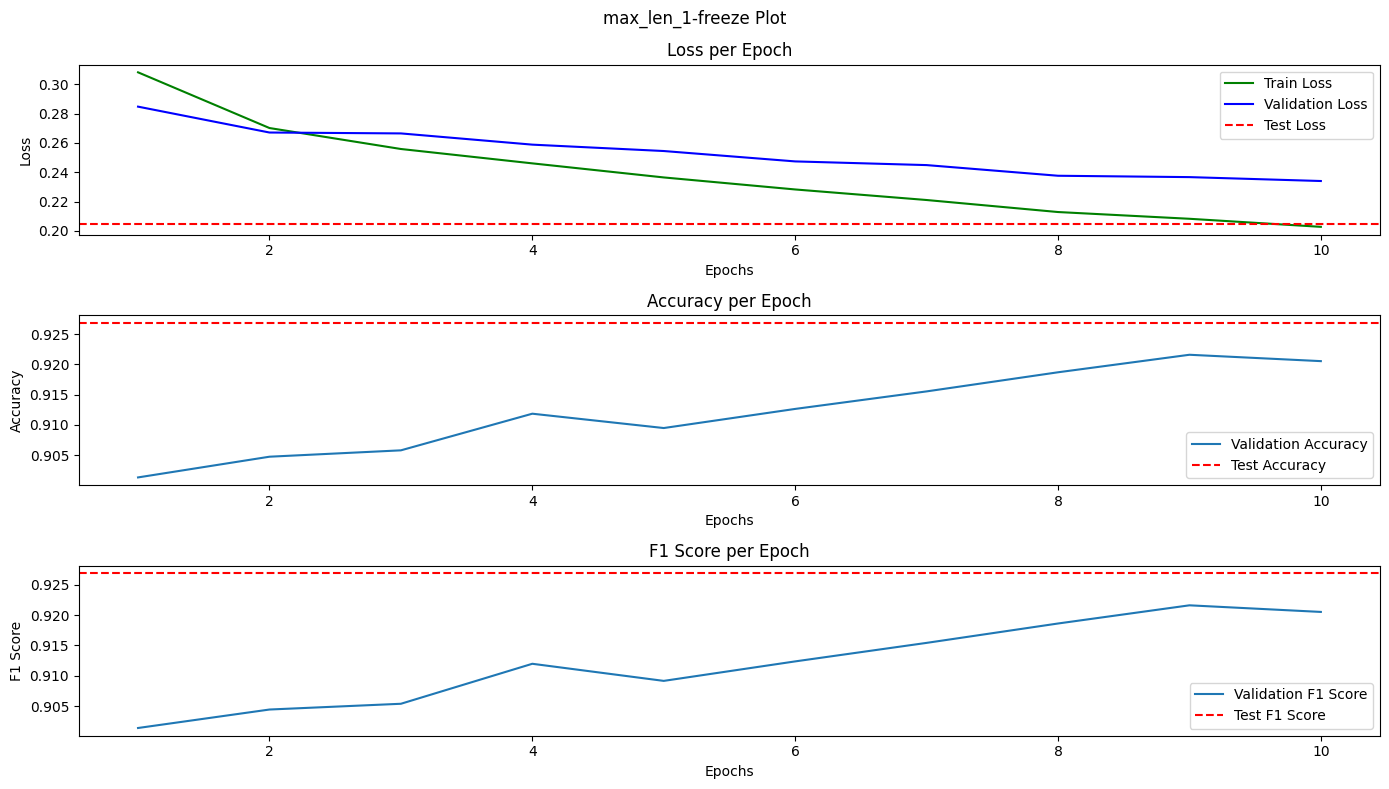

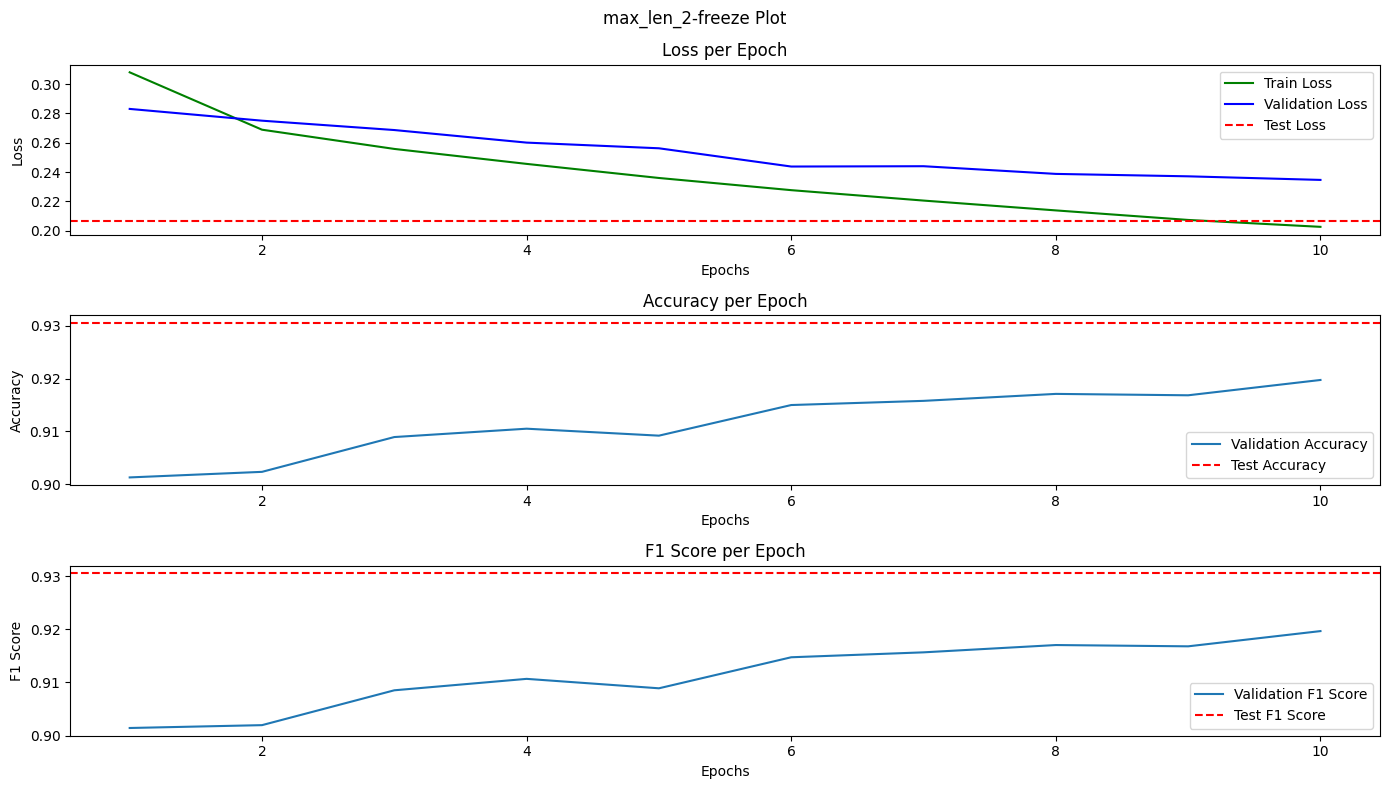

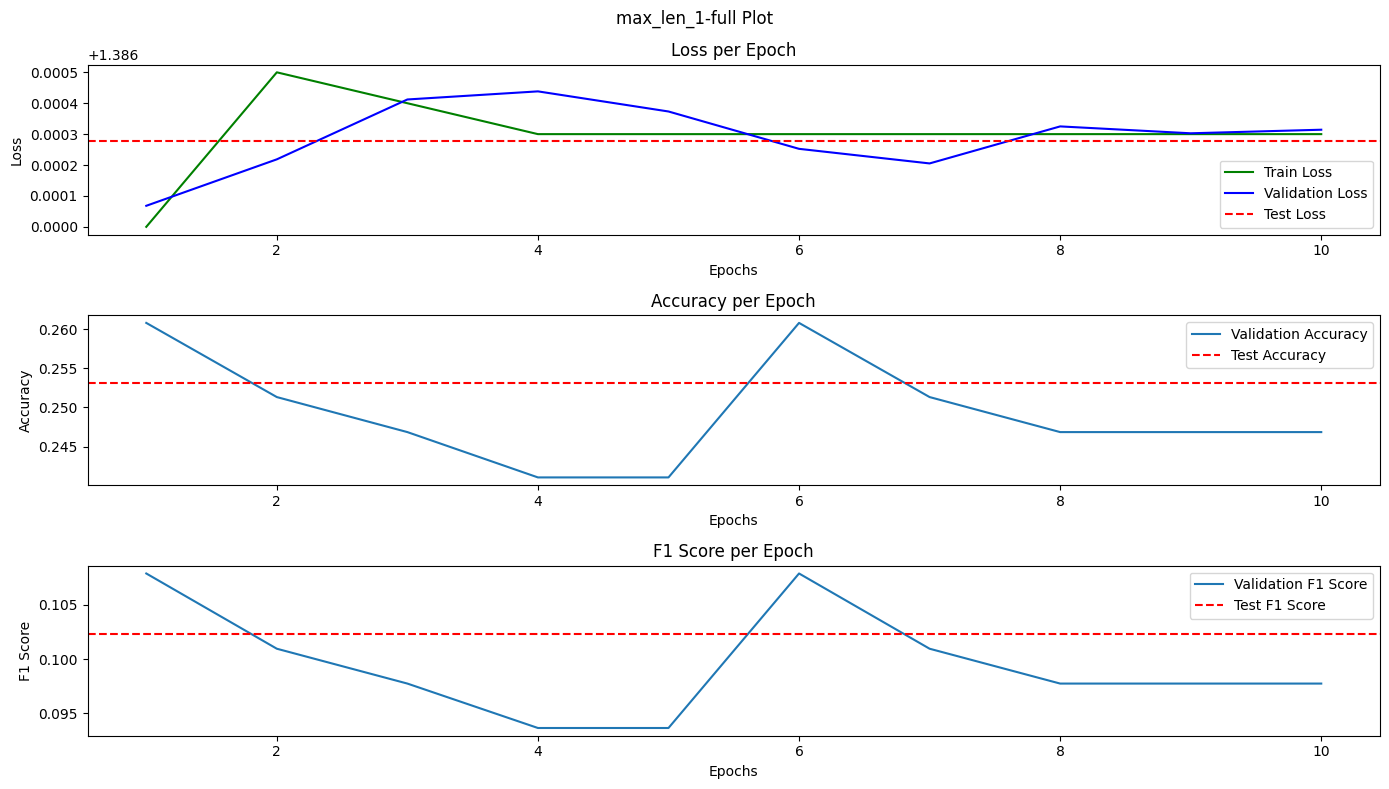

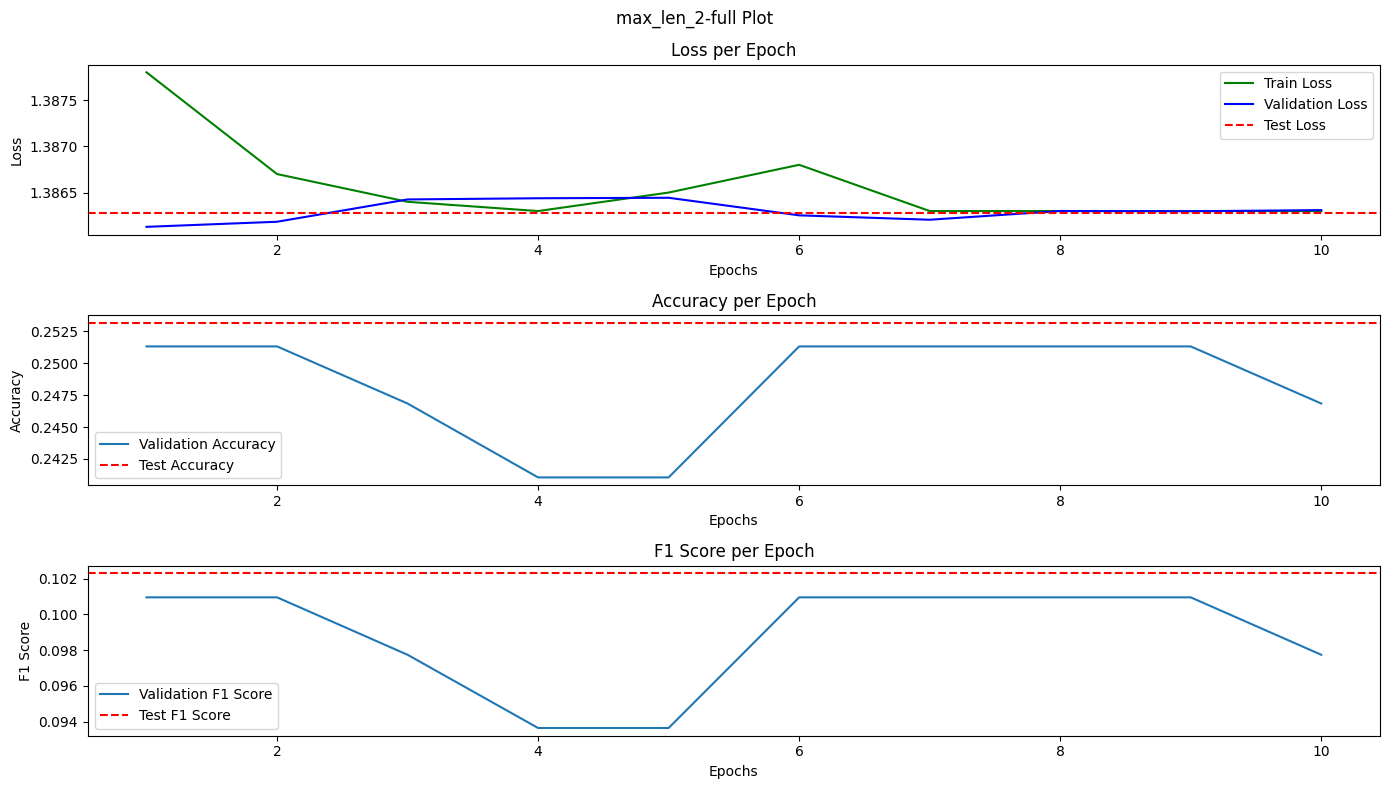

In [33]:
import matplotlib.pyplot as plt

def plotting(max_len_type):
    # 로그 데이터 추출
    log_history = trainer_dict[max_len_type].state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_accuracy' in log:
                val_accuracy.append(log['eval_accuracy'])
            if 'eval_f1' in log:
                val_f1.append(log['eval_f1'])

    test_loss = metrics_dict[max_len_type]['test_loss']
    test_accuracy = metrics_dict[max_len_type]['test_accuracy']
    test_f1 = metrics_dict[max_len_type]['test_f1']

    # 플로팅
    plt.figure(figsize=(14, 8))

    # 손실 플롯
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # 정확도 및 F1 스코어 플롯
    plt.subplot(3, 1, 2)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()

    plt.suptitle(f"{max_len_type} Plot")
    plt.tight_layout()
    print("\n\n")

plotting('max_len_1-freeze')
plotting('max_len_2-freeze')
plotting('max_len_1-full')
plotting('max_len_2-full')
plt.show()

In [34]:
import pandas as pd

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = [count_trainable_parameters(model_dict[name]) for name in metrics_dict.keys()]
train_runtime_lst = [trainer_dict[name].state.log_history[-1]['train_runtime'] for name in  metrics_dict.keys()]

result_df = pd.DataFrame(metrics_dict).T
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
result_df[['test_loss','test_accuracy','test_f1','trainable_parameters', 'train_runtime', 'test_runtime']]

,test_loss,test_accuracy,test_f1,trainable_parameters,train_runtime,test_runtime
max_len_1-freeze,0.204583,0.926842,0.926846,593668,3475.3184,10.3158
max_len_2-freeze,0.206604,0.930526,0.930505,593668,2015.2845,5.8400
max_len_1-full,1.386277,0.253158,0.102284,66956548,9082.5541,10.2685
max_len_2-full,1.386279,0.253158,0.102284,66956548,5153.2716,5.8315


## 5. [My Code] Conclusion

1) max_len을 200으로 줄였을 때 metirc은 거의 차이가 없으며 오히려 짧은 max_len에서 사소하지만 metric이 높은 것을 알 수 있습니다. 그러나 훈련시간은 2배 가까이 차이가 났습니다. 이는 뉴스기사는 기본 두괄식 작성법을 사용하기 때문에 앞부분에 어떤 주제인지 모두 드러나기 때문으로 생각됩니다. 즉, 200으로 해도 어떤 주제에 관한 글인지 확인할 수 있기에 metric에선 변화가 거의 없지만 거쳐가는 파라미터 수가 줄어들면서 훈련 시간은 많이 줄었습니다.

2) full finetuning을 함으로써 pre training에서 훈련된 파라미터가 많이 영향을 받아, 학습이 전혀 안 되었다고 볼 수 있습니다. 즉, Chatastrophic Forgetting이 발생했다고 분석할 수 있습니다.